## Import NPZ , load relevant parts

In [2]:
import numpy as np

canary_npz_dir = "/home/george-vengrovski/Documents/projects/TinyBird/results/eval_experiments/Talapas_Run_2/canary/llb3_annot/embeddings.npz"
zf_npz_dir = "/home/george-vengrovski/Documents/projects/TinyBird/results/eval_experiments/Talapas_Run_2/zebrafinch/G255/embeddings.npz"

zf_npz = np.load(zf_npz_dir)
canary_npz = np.load(canary_npz_dir)

print(zf_npz.files)

zf_spec = zf_npz["spectrograms"]
zf_labels_original = zf_npz["labels_original"]
zf_labels_downsampled = zf_npz["labels_downsampled"]
zf_encoded_embeddings_before_pos_removal = zf_npz["encoded_embeddings_before_pos_removal"]
zf_encoded_embeddings_after_pos_removal = zf_npz["encoded_embeddings_after_pos_removal"]
zf_patch_embeddings_before_pos_removal = zf_npz["patch_embeddings_before_pos_removal"]
zf_patch_embeddings_after_pos_removal = zf_npz["patch_embeddings_after_pos_removal"]
zf_patch_times =  zf_npz["num_patches_time"]
zf_model_num_timebins = zf_npz["model_num_timebins"]

canary_spec = canary_npz["spectrograms"]
canary_labels_original = canary_npz["labels_original"]
canary_labels_downsampled = canary_npz["labels_downsampled"]
canary_encoded_embeddings_before_pos_removal = canary_npz["encoded_embeddings_before_pos_removal"]
canary_encoded_embeddings_after_pos_removal = canary_npz["encoded_embeddings_after_pos_removal"]
canary_patch_embeddings_before_pos_removal = canary_npz["patch_embeddings_before_pos_removal"]
canary_patch_embeddings_after_pos_removal = canary_npz["patch_embeddings_after_pos_removal"]
canary_patches_time =  canary_npz["num_patches_time"]
canary_model_num_timebins = canary_npz["model_num_timebins"]



['spectrograms', 'labels_original', 'labels_downsampled', 'encoded_embeddings_before_pos_removal', 'encoded_embeddings_after_pos_removal', 'patch_embeddings_before_pos_removal', 'patch_embeddings_after_pos_removal', 'pos_ids', 'audio_sr', 'audio_n_mels', 'audio_hop_size', 'audio_fft', 'patch_height', 'patch_width', 'num_patches_time', 'num_patches_height', 'checkpoint', 'model_num_timebins', 'mels']


In [3]:
up_sample_embedding_factor = zf_model_num_timebins // zf_patch_times
print(up_sample_embedding_factor)

1


In [4]:
def negative_sim(embedding):
    embedding_t_0 = embedding[:-1]
    embedding_t_1 = embedding[1:]

    # Compute cosine similarity
    dot_prod = np.sum(embedding_t_0 * embedding_t_1, axis=1)
    # norm_t_0 = np.linalg.norm(embedding_t_0, axis=1)
    # norm_t_1 = np.linalg.norm(embedding_t_1, axis=1)
    # cosine_sim = dot_prod / (norm_t_0 * norm_t_1)
    
    # # Compute derivative (first difference)
    # derivative = np.diff(dot_prod)

    # print(cosine_sim.shape)
    
    return -dot_prod

def difference(embedding):    
    # Compute difference

    embedding = np.sum(embedding,axis=1)
    diff = np.diff(embedding, axis=0)
    return -diff 



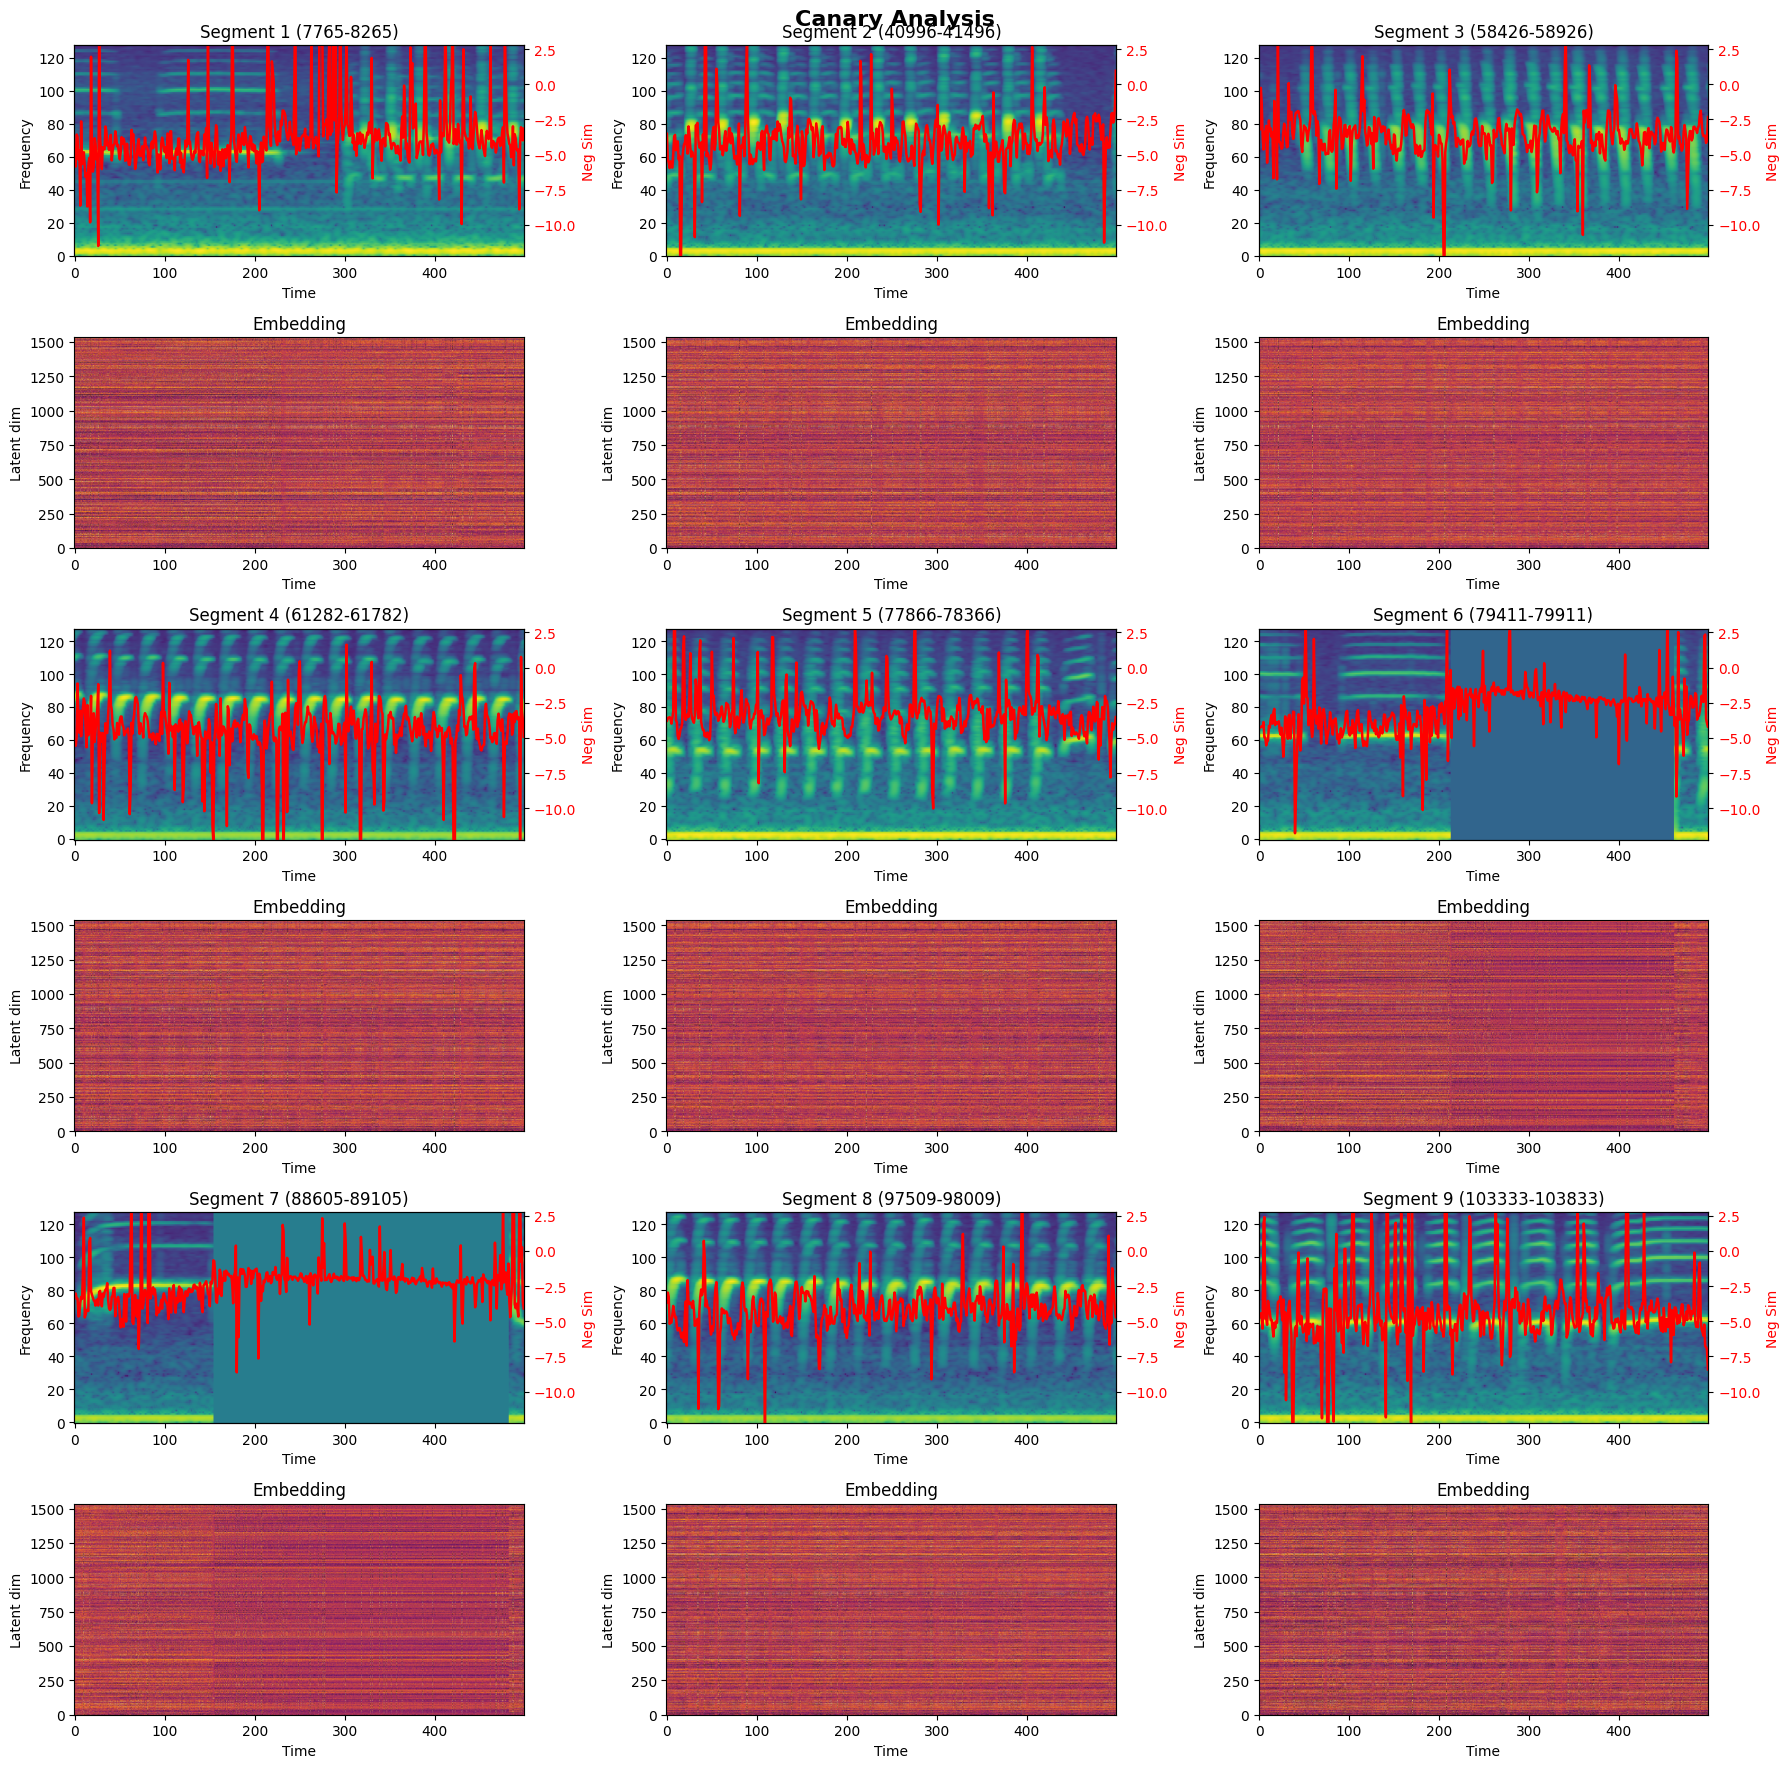

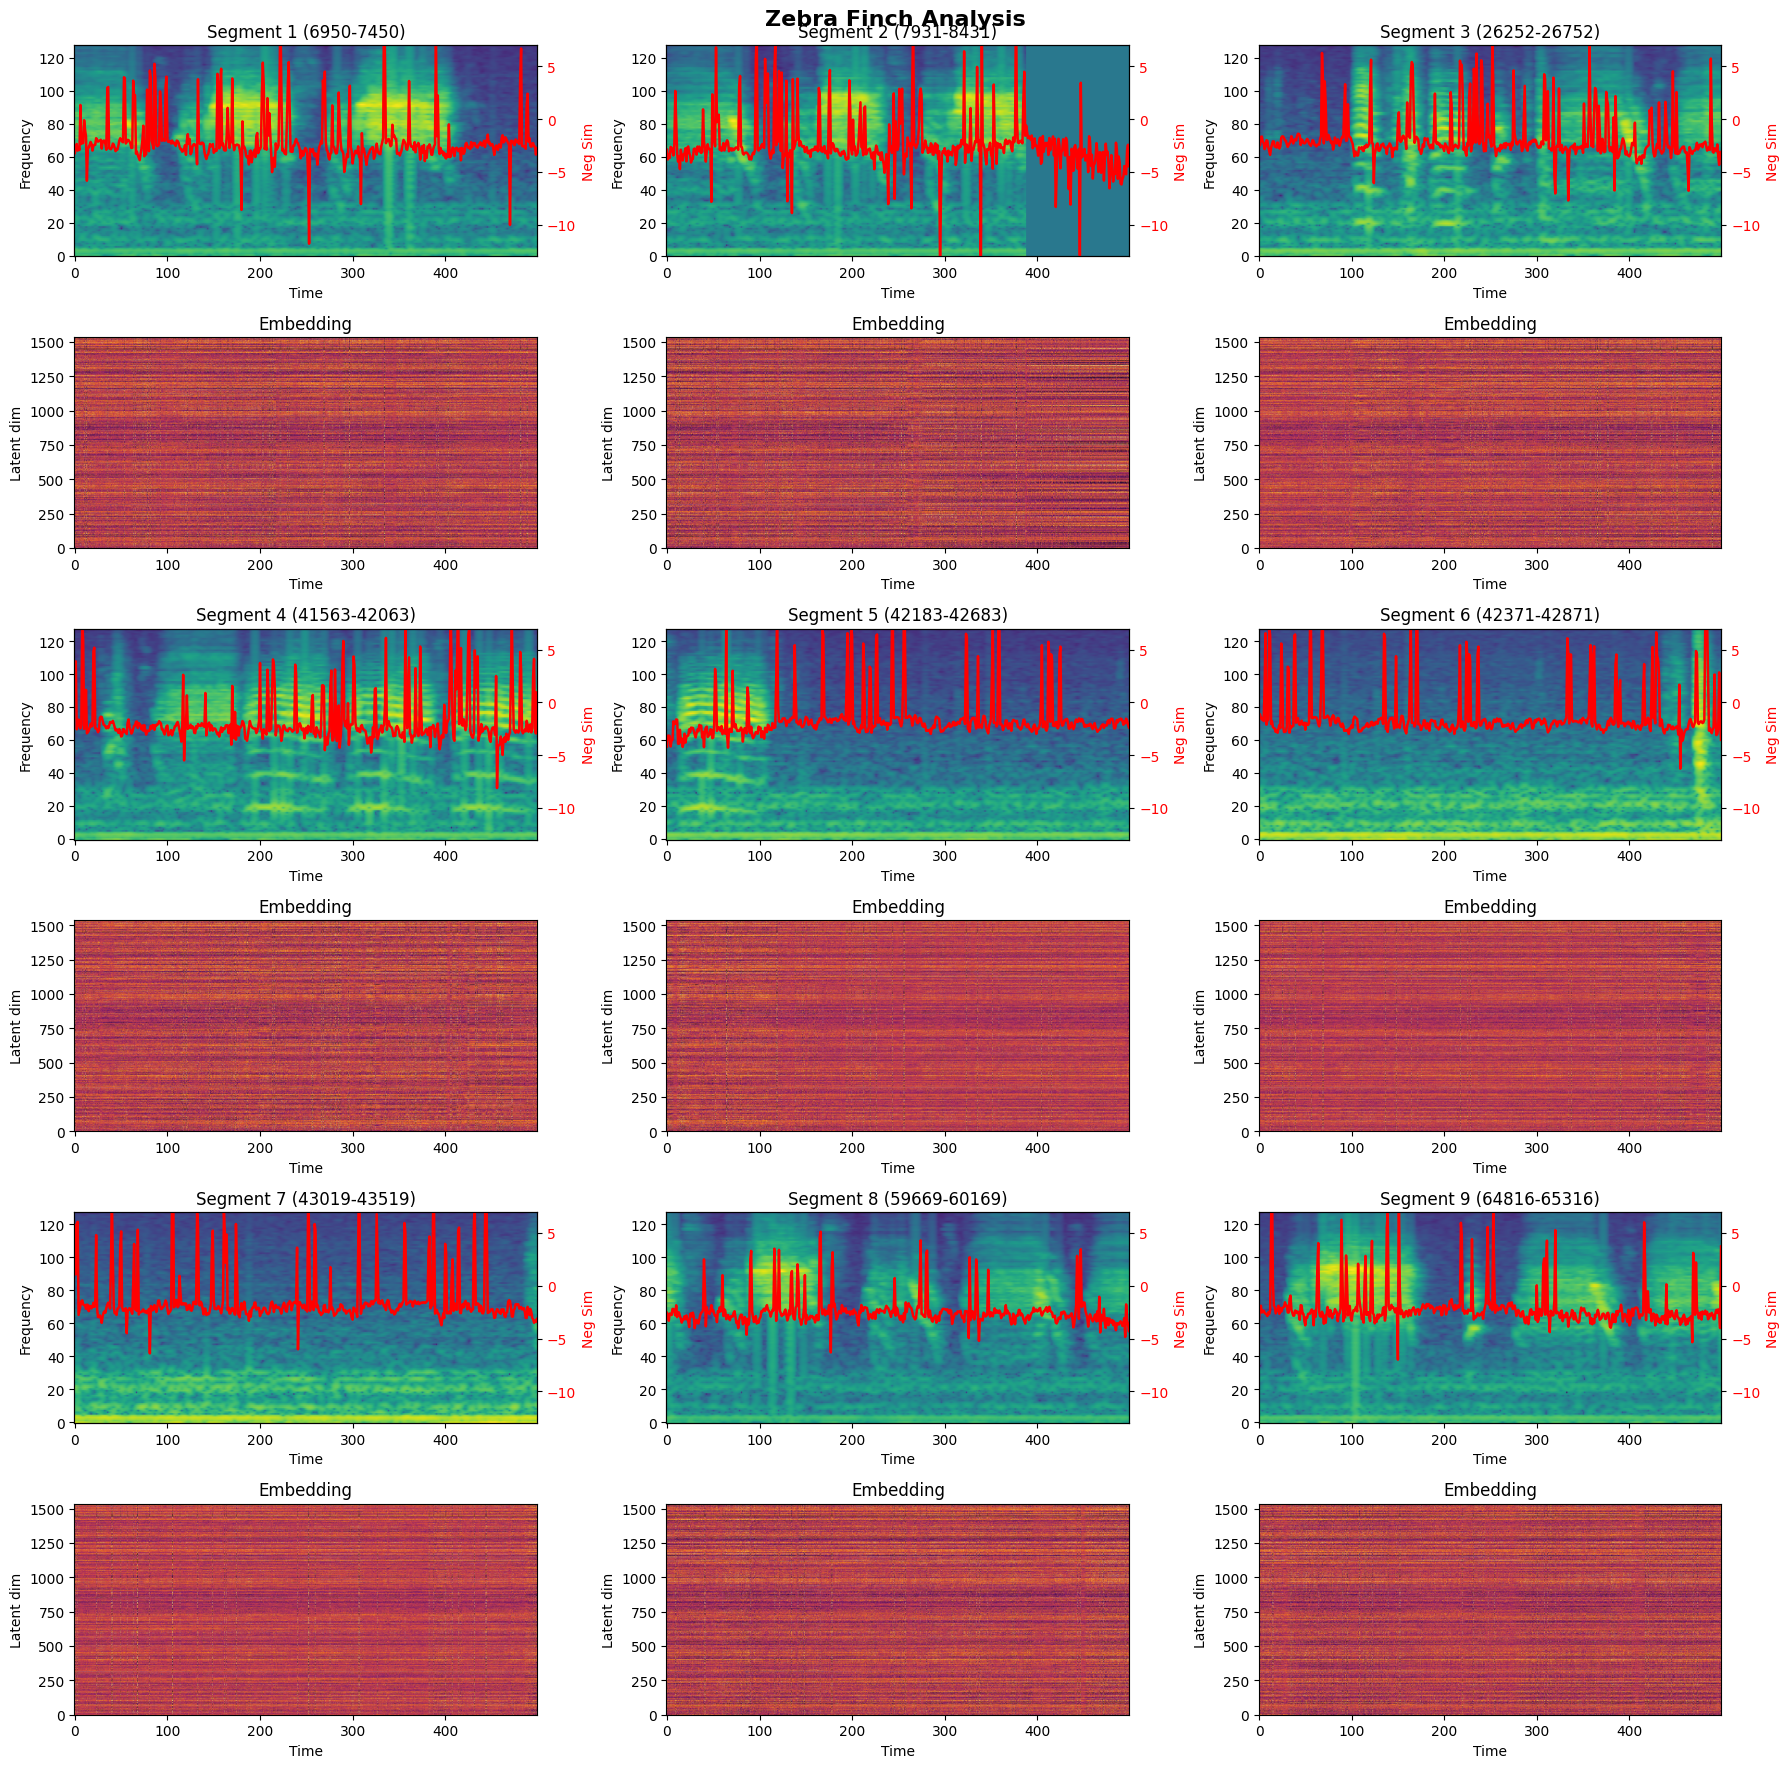

In [5]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

# Function to create a collage with spectrograms and latent embeddings
def create_collage(embedding, spec, title, up_sample_embedding_factor=1):
    # Upsample embeddings by repeating each timebin
    if up_sample_embedding_factor > 1:
        embedding = np.repeat(embedding, up_sample_embedding_factor, axis=0)
    
    # 1D score for line plot
    neg_sim = negative_sim(embedding)  # shape: [time]
    # Global robust limits for consistent y-scale across panels
    ns_p1, ns_p99 = np.percentile(neg_sim, [1, 99])
    
    # Robust global z-score (MAD) so all panels share a comparable scale
    med = np.median(embedding)
    mad = np.median(np.abs(embedding - med)) + 1e-12
    emb_z = (embedding - med) / (1.4826 * mad)
    # Optional clip to suppress outliers; keeps contrast
    emb_z = np.clip(emb_z, -3, 3)
    
    # Create a 6x3 subplot grid: for each segment, spec on top, embedding below
    fig, axes = plt.subplots(6, 3, figsize=(18, 18))
    axes = axes.flatten()
    
    # Add overall title
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Get random windows of 500 timebins each
    max_start = len(embedding) - 500
    random_starts = np.random.choice(max_start, size=9, replace=False)
    random_starts = np.sort(random_starts)  # Sort for easier visualization
    
    # Loop through 9 random segments of 500 timebins each
    for i in range(9):
        start_idx = random_starts[i]
        end_idx = start_idx + 500
        
        # Extract segments
        spec_segment = spec[start_idx:end_idx]
        emb_segment  = emb_z[start_idx:end_idx]  # shape: [time, latent_dim]

        # Grid position: pair of rows per segment
        row_pair = (i // 3) * 2
        col = i % 3
        spec_ax_idx = row_pair * 3 + col
        emb_ax_idx  = (row_pair + 1) * 3 + col

        # Plot spectrogram (top)
        ax_spec = axes[spec_ax_idx]
        ax_spec.imshow(spec_segment.T, aspect='auto', origin='lower')
        ax_spec.set_xlabel('Time')
        ax_spec.set_ylabel('Frequency')
        ax_spec.set_title(f'Segment {i+1} ({start_idx}-{end_idx})')

        # Overlay negative similarity as a red line
        neg_seg = neg_sim[start_idx:end_idx]
        ax_line = ax_spec.twinx()
        ax_line.plot(neg_seg, linewidth=1.8, color='red')
        ax_line.set_ylabel('Neg Sim', color='red')
        ax_line.tick_params(axis='y', labelcolor='red')
        ax_line.set_ylim(ns_p1, ns_p99)

        # Plot latent embeddings as image (bottom)
        ax_emb = axes[emb_ax_idx]
        # Fixed vmin/vmax across the collage to preserve contrast
        # Use inferno colormap for embeddings
        ax_emb.imshow(emb_segment.T, aspect='auto', origin='lower',
                      vmin=-3, vmax=3, cmap='inferno')
        ax_emb.set_xlabel('Time')
        ax_emb.set_ylabel('Latent dim')
        ax_emb.set_title('Embedding')
    
    plt.tight_layout()
    plt.show()

# Create collage for canary
create_collage(canary_encoded_embeddings_before_pos_removal, canary_spec, 'Canary Analysis', up_sample_embedding_factor)

# Create collage for zebra finch
create_collage(zf_encoded_embeddings_before_pos_removal, zf_spec, 'Zebra Finch Analysis', up_sample_embedding_factor)

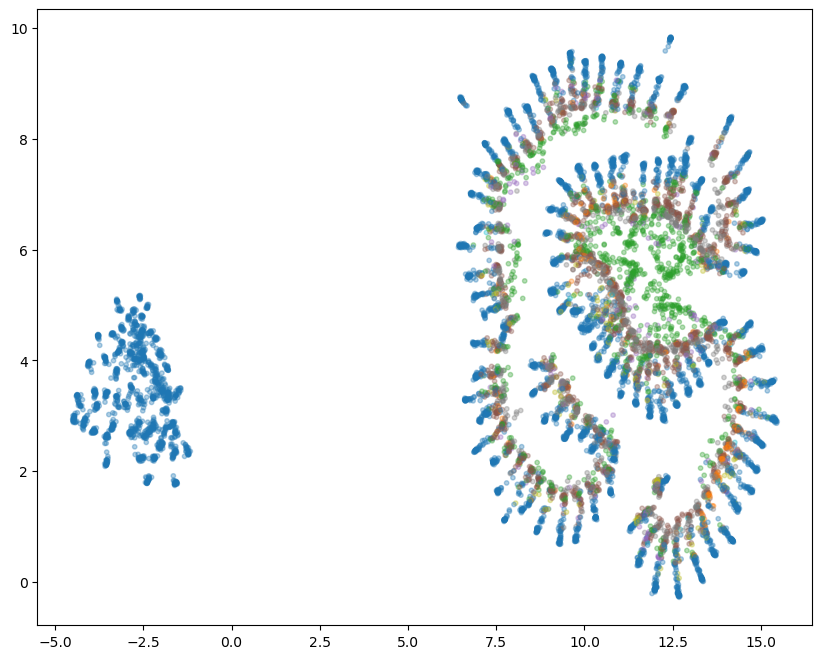

In [24]:
import numpy as np
import umap
import matplotlib.pyplot as plt



# Apply UMAP
reducer = umap.UMAP(n_neighbors=100, min_dist=0.1, metric='cosine', low_memory=True, n_jobs=-1)
umap_embeddings = reducer.fit_transform(zf_encoded_embeddings_after_pos_removal)

# Plot with original labels as colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], 
                     c=zf_labels_downsampled, cmap='tab10', s=10, alpha=0.35)

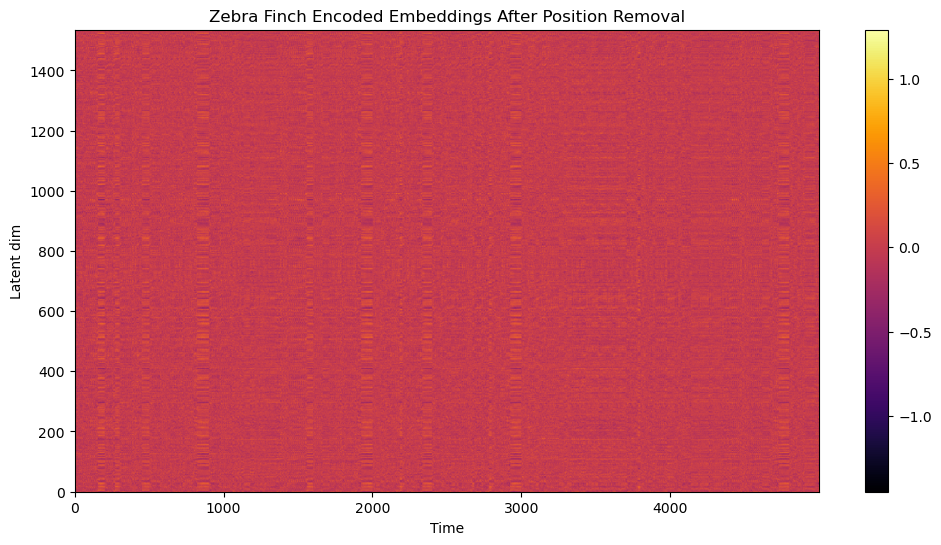

In [10]:
plt.figure(figsize=(12, 6))
plt.imshow(zf_encoded_embeddings_after_pos_removal[:5000].T, aspect='auto', origin='lower', cmap='inferno')
plt.xlabel('Time')
plt.ylabel('Latent dim')
plt.title('Zebra Finch Encoded Embeddings After Position Removal')
plt.colorbar()
plt.show()